In [1]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
os.listdir("./pickle")

['train_pickle.pickle', 'test_pickle.pickle']

In [3]:
def get_dataset_labels(filename):
    def get_pickle(filename):
        with open(filename, "rb") as file:
            return pickle.load(file)
    pickles = get_pickle(filename)
    return pickles['dataset'], pickles['labels']
    
train_dataset, train_labels = get_dataset_labels("./pickle/train_pickle.pickle")
test_dataset,  test_labels  = get_dataset_labels("./pickle/test_pickle.pickle")
print("train dataset shape : ", train_dataset.shape)
print("train_labels.shape : ", train_labels.shape)

train dataset shape :  (33402, 64, 64)
train_labels.shape :  (33402,)


In [4]:
num_digits = 5
def get_max_digits(dataset, labels):
    keep = [i for i, label in enumerate(labels) if len(label) <= num_digits]
    return dataset[keep], labels[keep]

train_dataset, train_labels = get_max_digits( train_dataset, train_labels)
test_dataset,  test_labels  = get_max_digits( test_dataset, test_labels)

In [5]:
def show_shape(dataset, labels, data_type):
    print( data_type, " dataset shape : ", dataset.shape)
    print( data_type, " labels shape : ", labels.shape)

In [6]:
valid_size = int(train_dataset.shape[0] * 0.2)
valid_dataset = train_dataset[:valid_size]
valid_labels = train_labels[:valid_size]
train_dataset = train_dataset[valid_size:]
train_labels = train_labels[valid_size:]
show_shape( valid_dataset, valid_labels, "valid")
show_shape( train_dataset, train_labels, "train")
show_shape( test_dataset, test_labels, "test")

valid  dataset shape :  (6680, 64, 64)
valid  labels shape :  (6680,)
train  dataset shape :  (26721, 64, 64)
train  labels shape :  (26721,)
test  dataset shape :  (13068, 64, 64)
test  labels shape :  (13068,)


In [7]:
num_labels = 11
num_channels = 1

def reformat(dataset, labels):
    dataset_output = dataset.reshape(list(dataset.shape) + [1]).astype(np.float32)
    labels_output = np.array([ np.array([ ( np.arange(num_labels) == l).astype(np.float32)
                                        for l in np.append(row, [num_labels - 1] * (num_digits - len(row)), 0)])
                             for row in labels])
    return dataset_output, labels_output

In [8]:
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat( valid_dataset, valid_labels)
test_dataset, test_labels   = reformat( test_dataset, test_labels)
show_shape( train_dataset, train_labels, "train")
show_shape( valid_dataset, valid_labels, "valid")
show_shape( test_dataset, test_labels, "test")

train  dataset shape :  (26721, 64, 64, 1)
train  labels shape :  (26721, 5, 11)
valid  dataset shape :  (6680, 64, 64, 1)
valid  labels shape :  (6680, 5, 11)
test  dataset shape :  (13068, 64, 64, 1)
test  labels shape :  (13068, 5, 11)


Label :  [[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


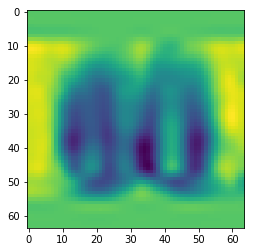

Label :  [[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


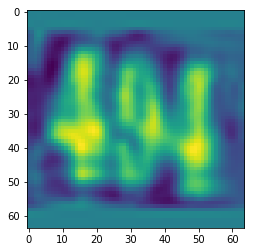

Label :  [[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


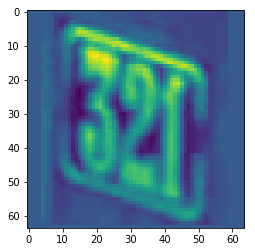

In [9]:
def show_image(img):
    img = img.reshape(img.shape[:2])
    plt.imshow(img)
    plt.show()

def show_images(dataset, labels, all_index):
    for index in all_index:
        print("Label : ", labels[index])
        show_image(dataset[index])        
rand_index = np.random.randint(0, train_dataset.shape[0], 3)
show_images( train_dataset, train_labels, rand_index)

In [10]:
batch_size = 64
img_size = train_dataset.shape[1]

In [15]:
def weight_variable(shape, name):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name=name)

def bias_variable(shape, name):
    return tf.Variable(tf.constant(0.1, shape=shape), name = name)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [18]:
kernel_size = 3
num_depth   = 64
use_max_pool = True
depth_fc = 1024 # fully connection unit count(depth)

graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, img_size, img_size, num_channels))
    tf_train_labels  = [tf.placeholder(tf.float32, shape=(batch_size, num_labels),
                                       name="tf_train_labels_%d" % index)
                        for index in range(num_digits)]
    
    w_conv1 = weight_variable([kernel_size, kernel_size, num_channels, num_depth], "weight_conv1")
    b_conv1 = bias_variable([num_depth], "bias_conv1")
    h_conv1 = tf.nn.relu(conv2d(tf_train_dataset, w_conv1) + b_conv1, name="relu_layer1")
    
    if use_max_pool:
        h_conv1 = max_pool_2x2(h_conv1)
    
    w_conv2 = weight_variable([kernel_size, kernel_size, num_depth, num_depth * 2], "weight_conv2")
    b_conv2 = bias_variable([num_depth * 2], "bias_conv2")
    h_conv2 = tf.nn.relu(conv2d(h_conv1, w_conv2) + b_conv2, name="relu_layer2")
    
    if use_max_pool:
        h_conv2 = max_pool_2x2(h_conv2)
        img_size_fc = int(img_size / 4 * img_size / 4 * num_depth * 2)
    else:
        img_size_fc = int(img_size * img_size * num_depth * 2)
    w_fc1 = weight_variable([img_size_fc, depth_fc], "fc1_weight")
    b_fc1 = bias_variable([depth_fc], "fc1_bias")
    
    h_conv2_flat = tf.reshape(h_conv2, [-1, img_size_fc])
    h_fc1 = tf.nn.relu(tf.matmul(h_conv2_flat, w_fc1) + b_fc1)
        
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    
    w_fc2 = weight_variable([depth_fc, num_digits * num_labels], "fc2_weight")
    b_fc2 = bias_variable([num_digits * num_labels], "fc2_bias")

In [14]:
tf.nn.relu?